In [15]:
## General import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Local imports
from functions import create_corr_plot, create_decomposition_plots, create_lag_features, plot_corr_matrix

import warnings
warnings.filterwarnings('ignore')

## Loading datasets and data cleaning

In [2]:
epi = pd.read_csv('epi_data/peru_epi_curve.csv')
epi['date'] = pd.to_datetime(epi.end_date)
epi.set_index('date', inplace=True)
epi = epi[['total_cases']]
epi

,total_cases
date,
2014-01-04,148.0
2014-01-11,529.0
2014-01-18,554.0
2014-01-25,800.0
2014-02-01,631.0
...,...
2023-12-09,NaN
2023-12-16,NaN
2023-12-23,NaN


In [3]:
climate = pd.read_csv('climate_data/climate.csv')
climate['date'] = pd.to_datetime(climate.date)
climate.set_index('date', inplace=True)
climate

,prec,tmin,tmax,tmean,dewmean,sst
date,,,,,,
2014-01-01,12.7741,15.9224,23.7535,19.3341,16.1681,20.4245
2014-01-02,6.5437,15.6130,24.4300,19.4051,16.2823,20.6550
2014-01-03,9.3538,15.9890,24.1155,19.4542,16.3900,20.6832
2014-01-04,17.4176,16.8189,22.5301,18.9587,16.9359,20.7810
2014-01-05,13.3024,16.3597,22.3466,18.7013,16.5964,20.8283
...,...,...,...,...,...,...
2023-07-28,2.7031,14.2116,24.7090,18.7873,12.5515,19.8688
2023-07-29,4.4093,14.6359,23.2919,18.2556,13.4881,19.8217
2023-07-30,1.8163,14.3946,24.1567,18.5359,13.2392,19.8946


In [4]:
df = pd.merge(left=epi[epi.index<'08-2023'], right=climate, left_index=True, right_index=True, how='outer')

## Calculating relative humidity in pcg
def calc_rh(df):
    num = np.exp((17.625 * df.dewmean)/(243.04 + df.dewmean))
    den = np.exp((17.625 * df.tmean)/(243.04 + df.tmean))
    return 100 * (num/den)

df['rh'] = df.apply(calc_rh, axis=1)
df

,total_cases,prec,tmin,tmax,tmean,dewmean,sst,rh
date,,,,,,,,
2014-01-01,NaN,12.7741,15.9224,23.7535,19.3341,16.1681,20.4245,81.921345
2014-01-02,NaN,6.5437,15.6130,24.4300,19.4051,16.2823,20.6550,82.156037
2014-01-03,NaN,9.3538,15.9890,24.1155,19.4542,16.3900,20.6832,82.469189
2014-01-04,148.0,17.4176,16.8189,22.5301,18.9587,16.9359,20.7810,88.054710
2014-01-05,NaN,13.3024,16.3597,22.3466,18.7013,16.5964,20.8283,87.574661
...,...,...,...,...,...,...,...,...
2023-07-27,NaN,3.3928,14.4183,25.4029,19.3404,12.1644,19.9681,63.187712
2023-07-28,NaN,2.7031,14.2116,24.7090,18.7873,12.5515,19.8688,67.088908
2023-07-29,5279.0,4.4093,14.6359,23.2919,18.2556,13.4881,19.8217,73.736623


In [5]:
df = df.groupby(pd.Grouper(freq='W')).agg({
                                    'total_cases':'sum',
                                    'prec':'sum',
                                    'tmin':'min',
                                    'tmax':'max',
                                    'rh':'mean',
                                    'tmean':'mean',
                                    'dewmean':'mean',
                                    'sst':'mean'})

df = df[df.index<'08-2023']
df

,total_cases,prec,tmin,tmax,rh,tmean,dewmean,sst
date,,,,,,,,
2014-01-05,148.0,59.3916,15.6130,24.4300,84.435188,19.170680,16.474540,20.674400
2014-01-12,529.0,71.2206,15.8745,23.7401,86.243194,18.950586,16.595429,21.208071
2014-01-19,554.0,62.8466,16.0232,24.1524,85.445722,19.161543,16.659243,22.133929
2014-01-26,800.0,55.2614,15.6403,25.1496,82.265466,19.681814,16.564643,22.219929
2014-02-02,631.0,69.0824,15.3336,24.1154,84.330184,18.998157,16.290700,20.983814
...,...,...,...,...,...,...,...,...
2023-07-02,9048.0,15.8024,13.3343,25.1386,67.512433,18.562914,12.427814,20.791600
2023-07-09,8616.0,16.6662,13.5939,26.0664,65.659708,19.233914,12.638914,20.703343
2023-07-16,7998.0,13.6211,14.0597,26.2773,67.442328,19.062843,12.890729,20.526743


In [6]:
df.rename(columns={'total_cases': 'cases'}, inplace=True)

## save dataframe to file
# df.to_csv('peru_final.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2014-01-05 to 2023-07-30
Freq: W-SUN
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cases    500 non-null    float64
 1   prec     500 non-null    float64
 2   tmin     500 non-null    float64
 3   tmax     500 non-null    float64
 4   rh       500 non-null    float64
 5   tmean    500 non-null    float64
 6   dewmean  500 non-null    float64
 7   sst      500 non-null    float64
dtypes: float64(8)
memory usage: 35.2 KB


## Exploratory Analysis

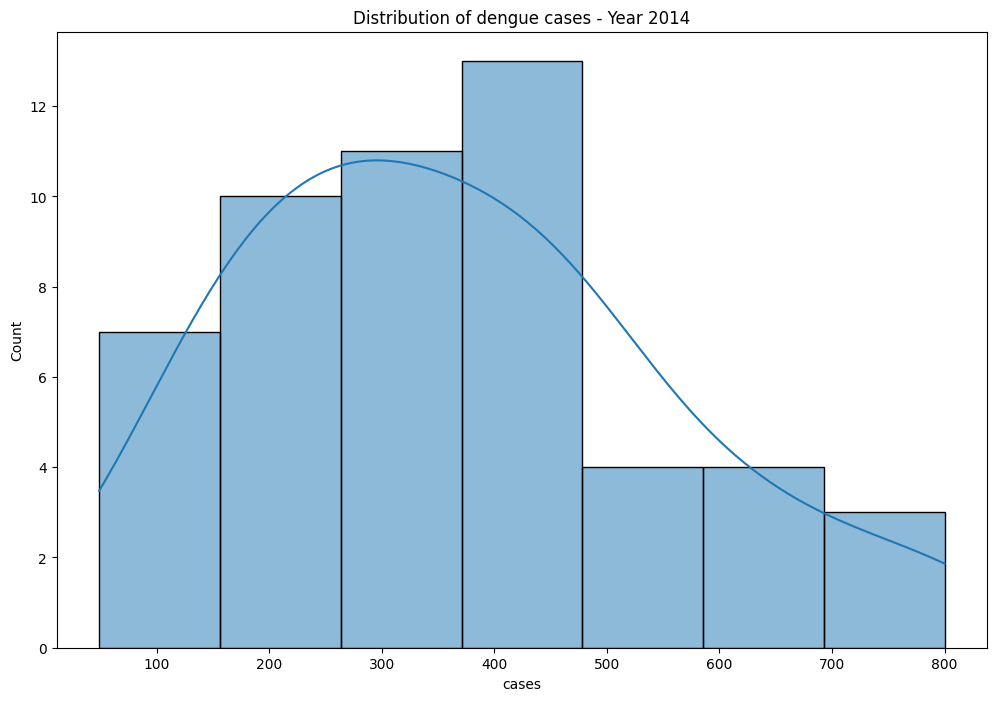

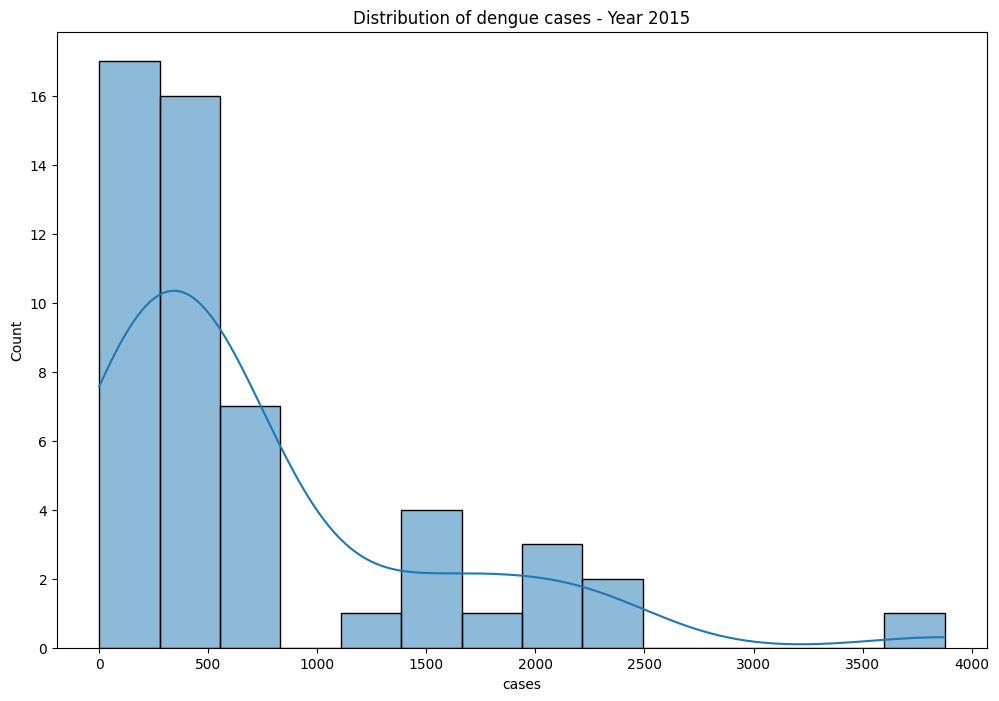

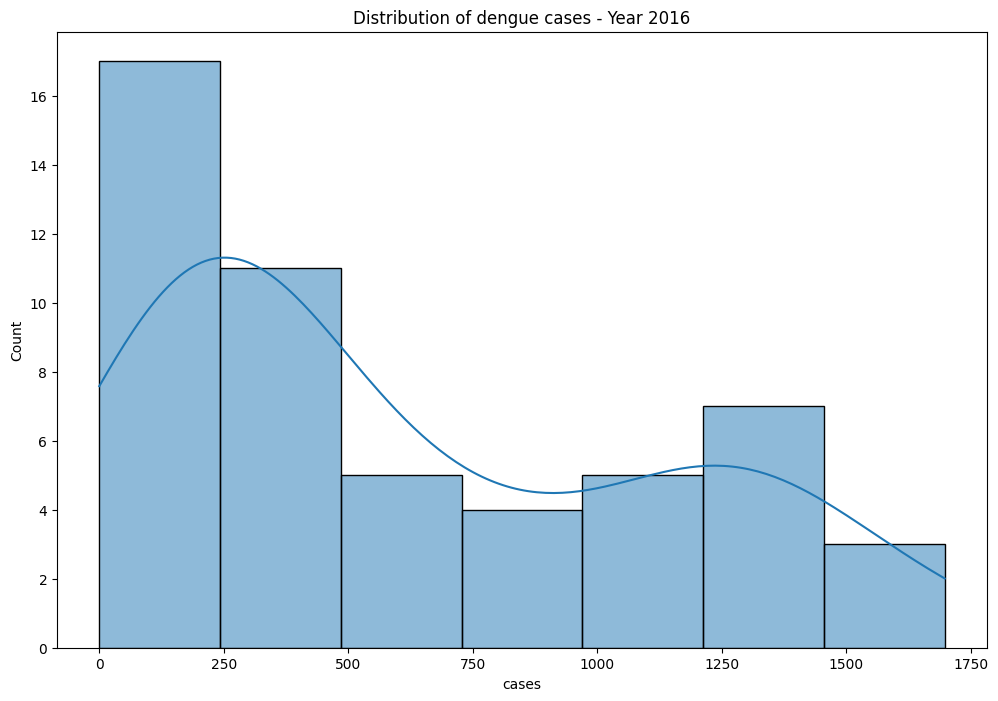

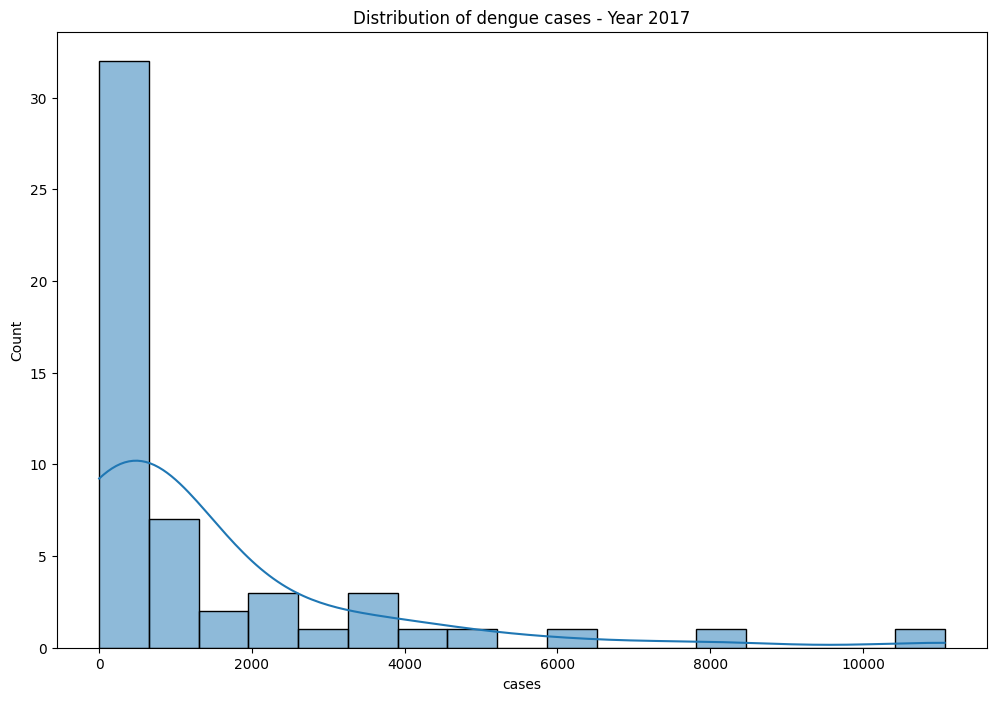

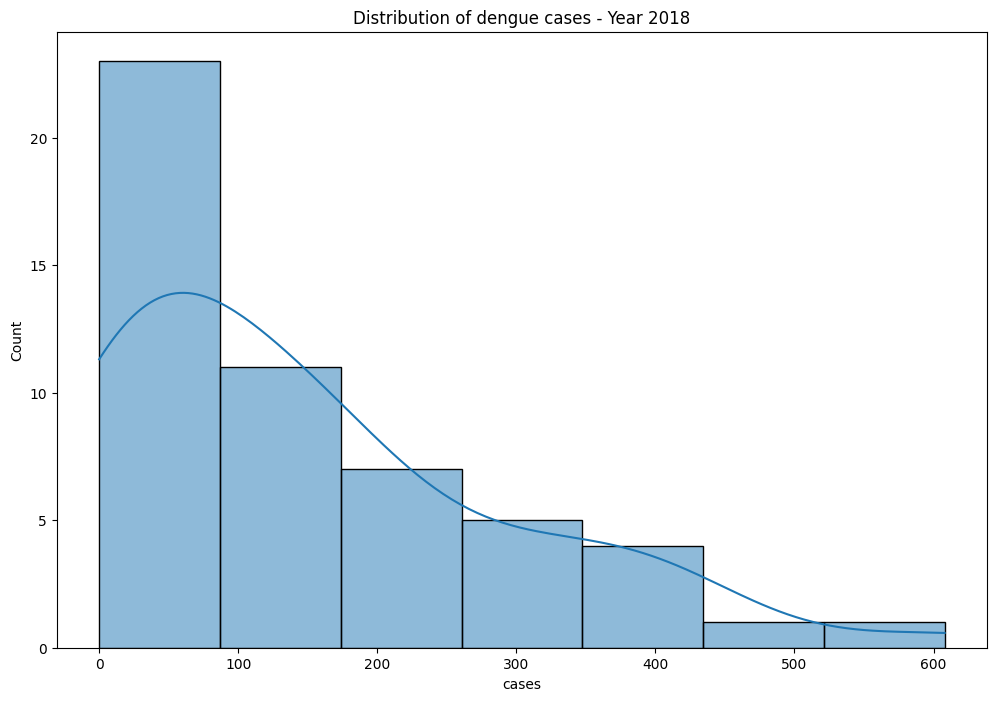

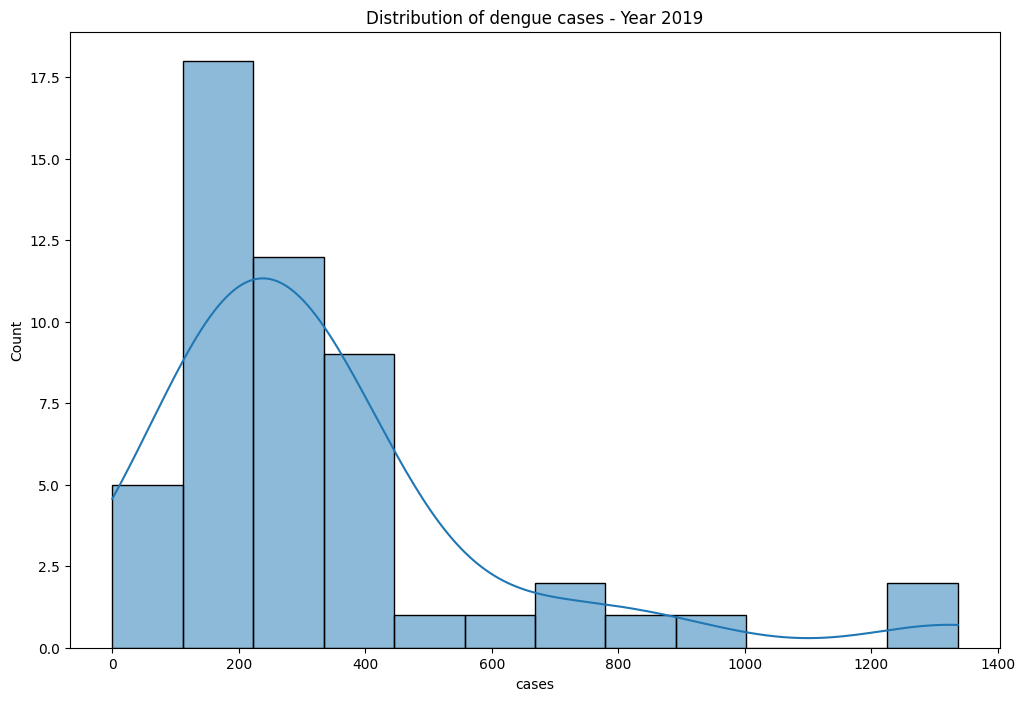

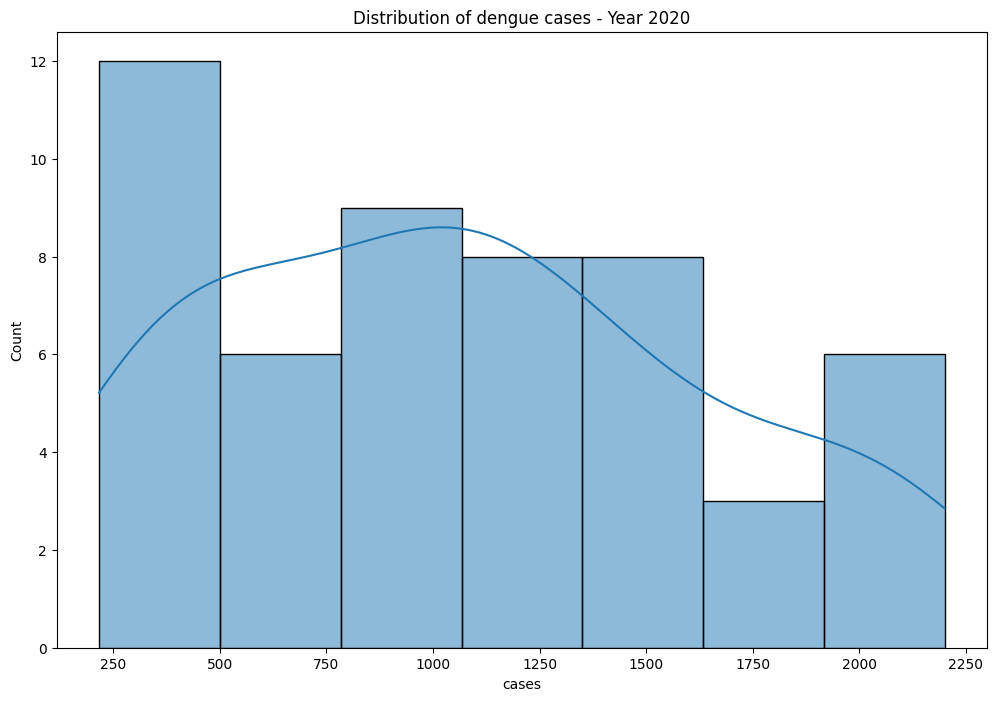

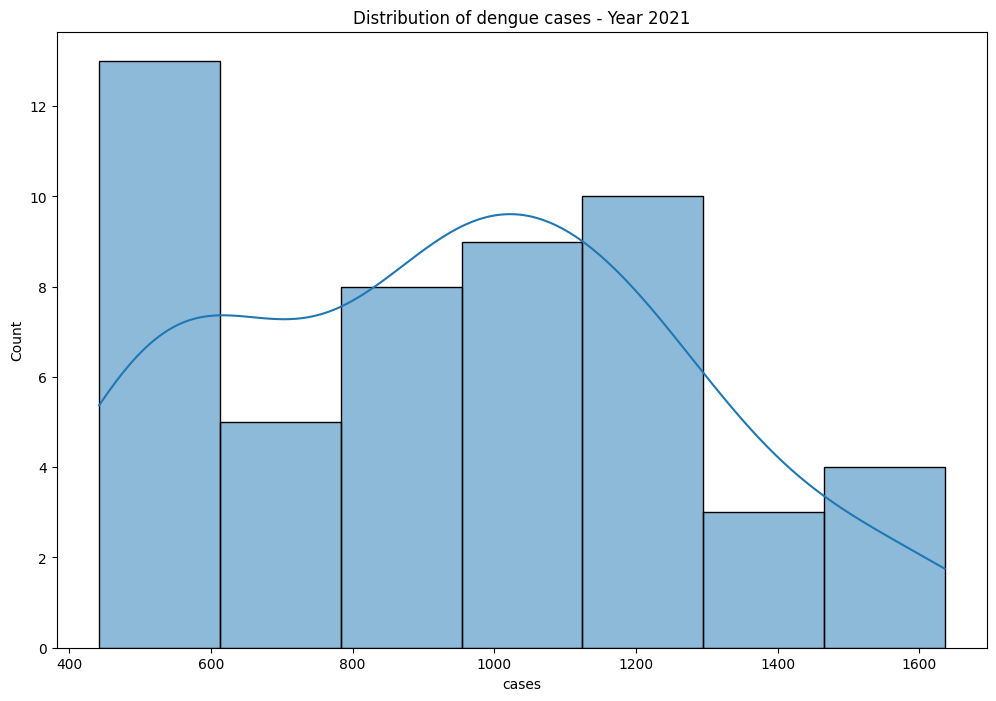

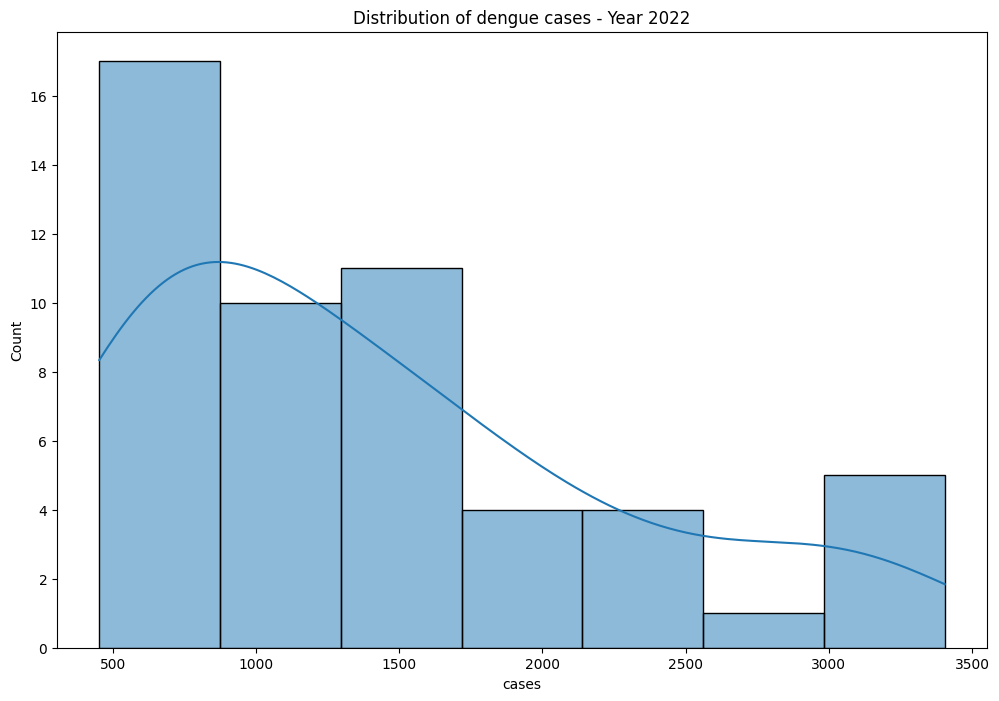

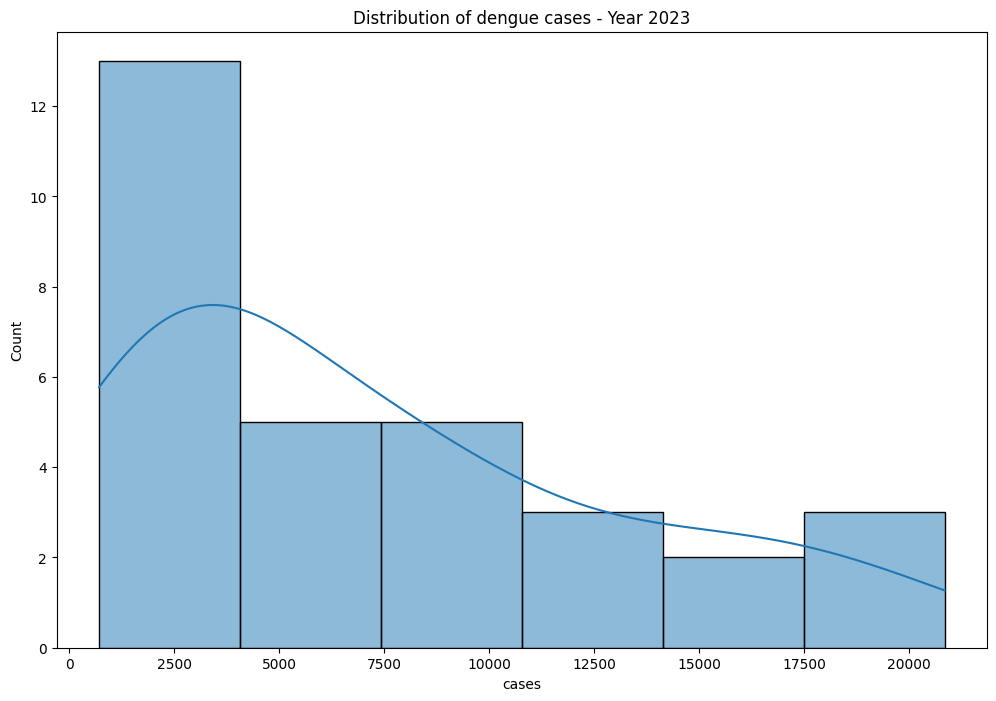

In [9]:
for year in df.index.year.unique():

    fig = plt.figure(figsize=(12,8))
    
    sns.histplot(
        data=df[df.index.year == year],
        x='cases',
        # hue=df.index.year,
        kde=True,
        )
    
    plt.title(f'Distribution of dengue cases - Year {year}')

    plt.show()

In [8]:
median = df['cases'].median()
mean = df['cases'].mean()

fig = px.histogram(data_frame=df,
                   x=df['cases'],
                   title='Distribution of Dengue cases (2014-2023)')

fig.add_vline(x=median, line_dash='dash', line_color='green', annotation_text='Median', annotation_position='top left')
fig.add_vline(x=mean, line_dash='dash', line_color='red', annotation_text='Mean')


fig.show()


## Stationarity, seasonality, trend

In [9]:
from statsmodels.tsa.stattools import adfuller

pval = adfuller(df['cases'])[1]
print('Stationary' if pval <= 0.05 else 'Non-stationary')


Stationary


In [10]:
create_corr_plot(df['cases'])

In [11]:
create_corr_plot(df['cases'], True)

In [12]:
create_decomposition_plots(df['cases'])

## Feature Engineering

Creating lag features automatically, looking at the partial autocorrelation plots for each feature and only creating the lags for PACF > 0.2 (i.e. 5% relevance for the lag)



In [13]:
df.columns

Index(['cases', 'prec', 'tmin', 'tmax', 'rh', 'tmean', 'dewmean', 'sst'], dtype='object')

In [14]:
tmp=[]
for col in df.columns:
    tmp.append(create_lag_features(df[col], col, scaler=False))

data = pd.concat(tmp, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2014-01-05 to 2023-07-30
Freq: W-SUN
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cases_lag_0    500 non-null    float64
 1   cases_lag_1    499 non-null    float64
 2   cases_lag_2    498 non-null    float64
 3   prec_lag_0     500 non-null    float64
 4   prec_lag_1     499 non-null    float64
 5   prec_lag_2     498 non-null    float64
 6   tmin_lag_0     500 non-null    float64
 7   tmin_lag_1     499 non-null    float64
 8   tmin_lag_2     498 non-null    float64
 9   tmax_lag_0     500 non-null    float64
 10  tmax_lag_1     499 non-null    float64
 11  tmax_lag_2     498 non-null    float64
 12  rh_lag_0       500 non-null    float64
 13  rh_lag_1       499 non-null    float64
 14  rh_lag_2       498 non-null    float64
 15  tmean_lag_0    500 non-null    float64
 16  tmean_lag_1    499 non-null    float64
 17  tmean_lag_2    498 non-

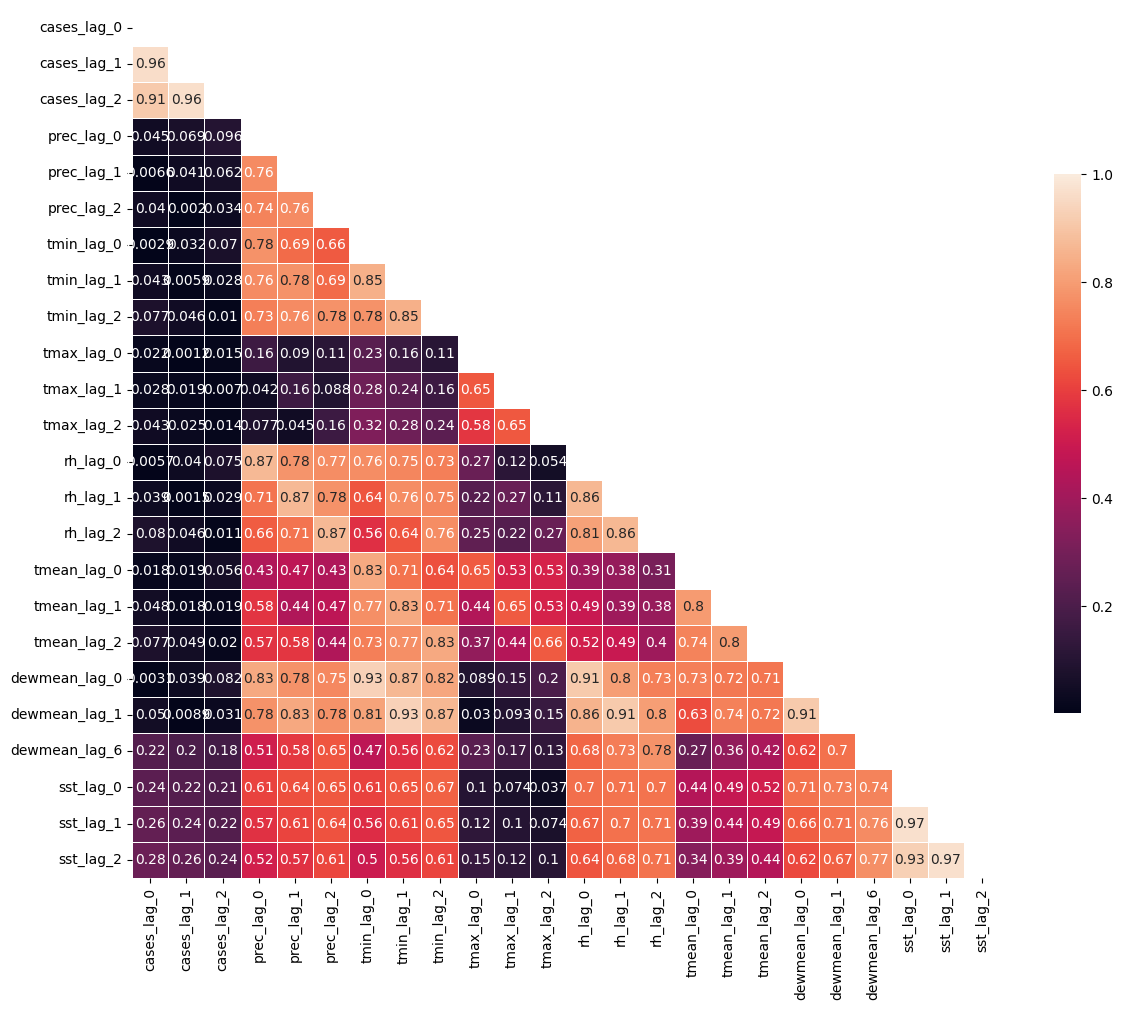

In [16]:
## Let's have a look at the correlation matrix

plot_corr_matrix(data)

In [18]:
## Selecting only relevant features

data = data[['cases_lag_0', 'cases_lag_1', 'cases_lag_2',
             'rh_lag_0', 'rh_lag_1', 'rh_lag_2', 
             'sst_lag_0', 'sst_lag_1', 'sst_lag_2',
             'dewmean_lag_0', 'dewmean_lag_1', 'dewmean_lag_6',
             'tmean_lag_0', 'tmean_lag_1', 'tmean_lag_2', 
             'prec_lag_0', 'prec_lag_1', 'prec_lag_2'
             ]]

data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 494 entries, 2014-02-16 to 2023-07-30
Freq: W-SUN
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cases_lag_0    494 non-null    float64
 1   cases_lag_1    494 non-null    float64
 2   cases_lag_2    494 non-null    float64
 3   rh_lag_0       494 non-null    float64
 4   rh_lag_1       494 non-null    float64
 5   rh_lag_2       494 non-null    float64
 6   sst_lag_0      494 non-null    float64
 7   sst_lag_1      494 non-null    float64
 8   sst_lag_2      494 non-null    float64
 9   dewmean_lag_0  494 non-null    float64
 10  dewmean_lag_1  494 non-null    float64
 11  dewmean_lag_6  494 non-null    float64
 12  tmean_lag_0    494 non-null    float64
 13  tmean_lag_1    494 non-null    float64
 14  tmean_lag_2    494 non-null    float64
 15  prec_lag_0     494 non-null    float64
 16  prec_lag_1     494 non-null    float64
 17  prec_lag_2     494 non-

In [20]:
print(f'Min: {data.index.min()}\nMax: {data.index.max()}')

Min: 2014-02-16 00:00:00
Max: 2023-07-30 00:00:00


## Modelling with XGBoost

In [21]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

from functions import print_scores, plot_true_pred, features_importance

In [22]:
## Splitting the dataset and keeping the last months to make forecast

X = data.loc[:'2023-01-01',:].drop('cases_lag_0', axis=1)
y = data.loc[:'2023-01-01','cases_lag_0']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Hyperparameters tuning with GridSearchCV

In [24]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 1000, 2500, 5000],
    'max_depth': [1, 2, 5],
}

gs = GridSearchCV(
    estimator=xgb.XGBRegressor(
        subsample=0.5,
        ),
    param_grid=param_grid,
    cv=tscv,
    verbose=5,
    scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'],
    refit='neg_root_mean_squared_error'
).fit(X_train, y_train)


y_pred = pd.Series(gs.predict(X_test), index=y_test.index)
plot_true_pred(y_train, y_test, y_pred, title='XGBoost w/ grid search')

mean_mae = gs.cv_results_['mean_test_neg_mean_absolute_error']
mean_rmse = gs.cv_results_['mean_test_neg_root_mean_squared_error']
std_mae = gs.cv_results_['std_test_neg_mean_absolute_error']
std_rmse = gs.cv_results_['std_test_neg_root_mean_squared_error']

print(f'Best parameters: {gs.best_params_}\nBest score: {gs.best_score_:.2f}')
print(f'MAE: {abs(mean_mae).min():.3f}\nRMSE: {abs(mean_rmse).min():.3f}')


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END learning_rate=0.1, max_depth=1, n_estimators=100; neg_mean_absolute_error: (test=-379.039) neg_root_mean_squared_error: (test=-600.052) r2: (test=0.267) total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=1, n_estimators=100; neg_mean_absolute_error: (test=-809.918) neg_root_mean_squared_error: (test=-1912.015) r2: (test=0.124) total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=1, n_estimators=100; neg_mean_absolute_error: (test=-165.309) neg_root_mean_squared_error: (test=-197.516) r2: (test=-1.199) total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=1, n_estimators=100; neg_mean_absolute_error: (test=-239.711) neg_root_mean_squared_error: (test=-338.260) r2: (test=-0.349) total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=1, n_estimators=100; neg_mean_absolute_error: (test=-265.012) neg_root_mean_squared_error: (test=-355.881) r2: (test=0.555) total time=   0.0s
[CV 1/5] E

Best parameters: {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 2500}
Best score: -648.98
MAE: 343.600
RMSE: 648.983


### Manual fine-tuning

In [55]:
xgb_reg = xgb.XGBRegressor(
    learning_rate=0.01,#0.003,
    n_estimators=580,#180,
    max_depth=3,
    subsample=0.5,
    # early_stopping_rounds=100,
)

xgb_reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_metric='rmse',
            verbose=100)

y_pred = pd.Series(xgb_reg.predict(X_test), index=y_test.index)

features_importance(xgb_reg)
# print_scores(xgb_reg, X_train, X_test, y_train, y_test)
plot_true_pred(y_train, y_test, y_pred, title='XGBoost')

from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

print(f'MAE: {mae:.3f}\nRMSE: {rmse:.3f}')
print(f'Train score: {xgb_reg.score(X_train, y_train):.3f}\nTest score: {xgb_reg.score(X_test,y_test):.3f}')
print(f'Test mean: {y_test.mean():.3f}\nTest median: {y_test.median():.3f}\nTest std: {y_test.std():.3f}')

[0]	validation_0-rmse:1211.74656	validation_1-rmse:1351.85377
[100]	validation_0-rmse:664.70695	validation_1-rmse:582.86313
[200]	validation_0-rmse:435.58268	validation_1-rmse:323.97271
[300]	validation_0-rmse:344.26541	validation_1-rmse:243.39420
[400]	validation_0-rmse:294.61146	validation_1-rmse:214.34195
[500]	validation_0-rmse:259.07510	validation_1-rmse:207.23197
[579]	validation_0-rmse:239.90850	validation_1-rmse:211.80869


MAE: 169.222
RMSE: 211.809
Train score: 0.944
Test score: 0.908
Test mean: 1174.118
Test median: 970.000
Test std: 701.540


In [56]:
print(f'RSR: {rmse/y_test.std():.3f}')

RSR: 0.302


The model has a 90.8% score on the test dataset, and a 94.4% score on the train dataset. The difference between the two scores is less than 5% thus we can say the model is NOT overfitting

## Prediction

In [86]:
data[data.index.year == 2023].index

DatetimeIndex(['2023-01-01', '2023-01-08', '2023-01-15', '2023-01-22',
               '2023-01-29', '2023-02-05', '2023-02-12', '2023-02-19',
               '2023-02-26', '2023-03-05', '2023-03-12', '2023-03-19',
               '2023-03-26', '2023-04-02', '2023-04-09', '2023-04-16',
               '2023-04-23', '2023-04-30', '2023-05-07', '2023-05-14',
               '2023-05-21', '2023-05-28', '2023-06-04', '2023-06-11',
               '2023-06-18', '2023-06-25', '2023-07-02', '2023-07-09',
               '2023-07-16', '2023-07-23', '2023-07-30'],
              dtype='datetime64[ns]', name='date', freq='W-SUN')

Using the model to make predictions on unseen data: forecasting the next 3 months, from January 1st to April 2nd 2023

In [84]:
X_train_future = data.loc[:'2023-01-08',:].drop('cases_lag_0', axis=1)
y_train_future = data.loc[:'2023-01-08','cases_lag_0']

X_future = data.loc['2023-01-01':'2023-04-02',:].drop('cases_lag_0', axis=1)
y_future = data.loc['2023-01-01':'2023-04-02','cases_lag_0']


xgb_reg.fit(X_train_future, y_train_future)

y_future_pred = pd.Series(xgb_reg.predict(X_future), index=y_future.index)
plot_true_pred(y_train_future, y_future, y_future_pred, title='XGBoost forecast', forecast=True)

mae = mean_absolute_error(y_future, y_future_pred)
rmse = np.sqrt(mean_squared_error(y_future, y_future_pred))

print(f'Future lags: {len(y_future_pred)} weeks')
print(f'MAE: {mae:.3f}\nRMSE: {rmse:.3f}')
print(f'Unseen mean: {y_future.mean():.3f}\nUnseen median: {y_future.median():.3f}\nUnseen std: {y_future.std():.3f}')

Future lags: 14 weeks
MAE: 275.365
RMSE: 340.386
Unseen mean: 2402.429
Unseen median: 2346.000
Unseen std: 916.966


In [85]:
print(f'RSR: {rmse/y_future.std():.3f}')

RSR: 0.371
